# HMM on simulated data (*simulations based on T. Ryden*)
This notebook showcases practical applications on simulated data.

## Importing Libraries
We start by importing the necessary libraries for the operations ahead.

In [1]:
import os
os.chdir('../../')

from inference_mahmm import *
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
import numpy as np

## Data Simulation and Visualization

In a first step, we simulate the Markov chain of observations $Y$ governed by the hidden Markov chain $X$. 

### Choosing the Parameters of the Model

We set up parameters for the *Hidden Markov Model* (HMM) with $K$ states:
* `ν`: The initial probabilities of being in each state.
* `Q`: The transition probabilities between states.
* `M`: The means of the Gaussian distributions for each state.
* `Σ`: The standard deviations of the Gaussian distributions for each state.
* `T`: The number of time steps.
* `K`: The number of states.

The parameters of the model are given in the paper *EM versus Markov chain Monte Carlo for estimation of hidden Markov models: a computational perspective*, Tobias Rydén:

$$\nu = \left(\begin{array}{ccc}0.2&0.6&0.2\end{array}\right)$$

$$Q = \left(\begin{array}{ccc}0.6&0.3& 0.1\\
0.1& 0.8& 0.1\\
0.1& 0.3& 0.6\end{array}\right)$$

$$M = \left(\begin{array}{ccc}-2&0&2\end{array}\right)$$

$$\Sigma = \left(\begin{array}{ccc}0.5&0.5&0.5\end{array}\right)$$

In [2]:
ν = np.array([.2, .6, .2])
Q = np.array([[.6, .3, .1],[.1, .8, .1],[.1, .3, .6]])
M = np.array([-2, 0, 2])
Σ = np.array([.5, .5, .5])
T, K, L = 1000, len(ν), 0
train_test_split = 0.7

In [3]:
HMM = ma_hmm(ν, Q, M, Σ, T, L)
HMM.simul(seed=1)

### Markov Chain $X$ of Hidden States

The Markov chain $X$ of latent states is generated from the matrix of initial probabilities $\nu$ and the matrix of transition probabilities $Q$:

$$x_0 \sim \mathcal{M}(\nu)$$

$$x_t \sim \mathcal{M}(Q_{x_{t-1}}) \quad \forall t > 0$$

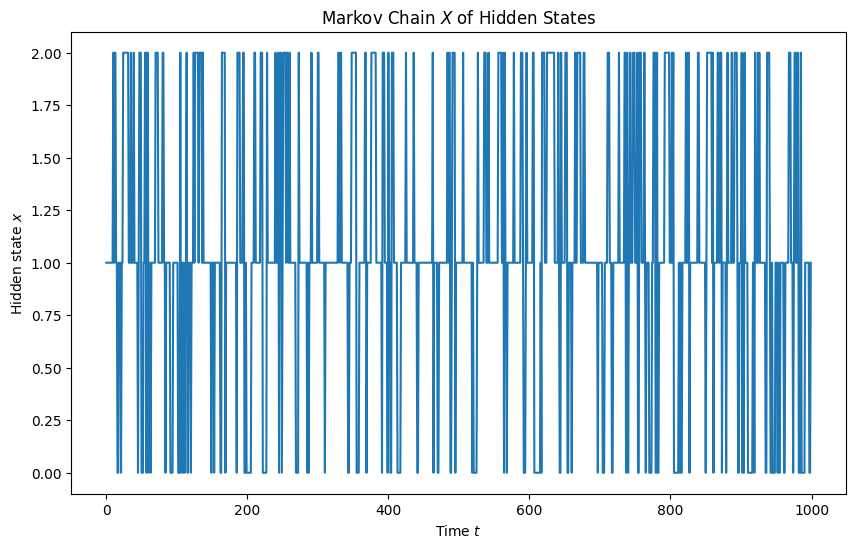

In [4]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(HMM.true_x)
plt.title('Markov Chain $X$ of Hidden States')
plt.xlabel('Time $t$')
plt.ylabel('Hidden state $x$')
plt.show()

### Markov Chain $Y$ of Observations
The Markov chain $Y$ of observations is normally distributed with parameters depending on the state of the unobserved process $X$:

$$y_t = f(x_t \vert \mu_{x_t}, \sigma_{x_t}) \quad \forall t \in [0, T]$$

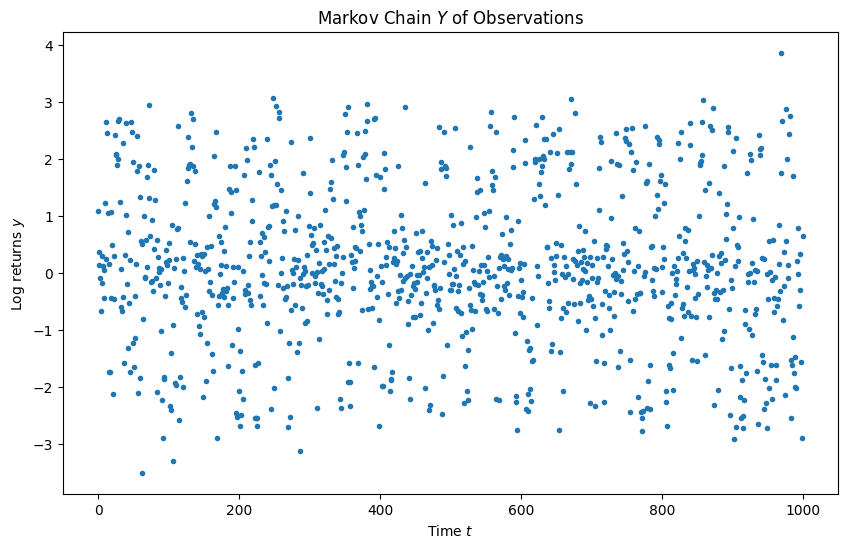

In [5]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(HMM.true_y, '.')
plt.title('Markov Chain $Y$ of Observations')
plt.xlabel('Time $t$')
plt.ylabel('Log returns $y$')
plt.show()

### Histogram of the data
Then, we vizualize the data by plotting its histogram.

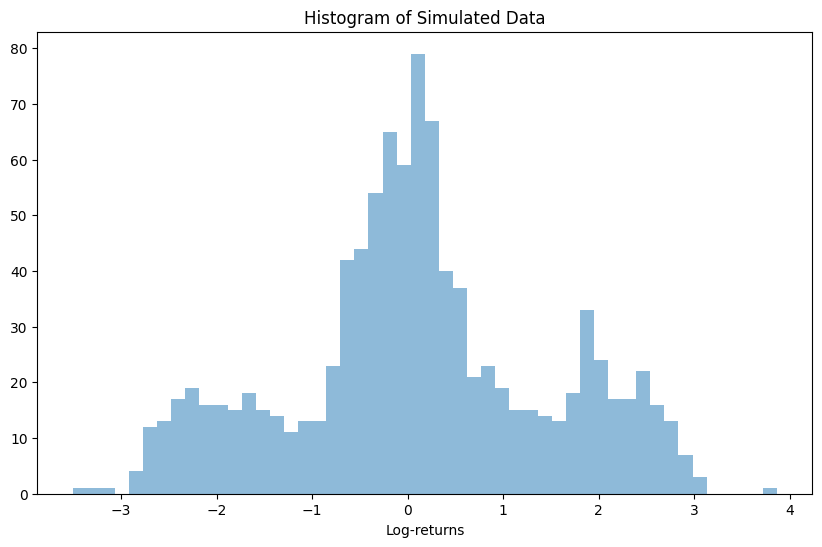

In [6]:
fig, ax = plt.subplots(figsize=(10,6))
plt.hist(HMM.true_y, bins=50, alpha=.5)
plt.title('Histogram of Simulated Data')
plt.xlabel('Log-returns')
plt.show()

### Price Trajectories
Finally, from the returns, we can calculate the resulting price trajectories.

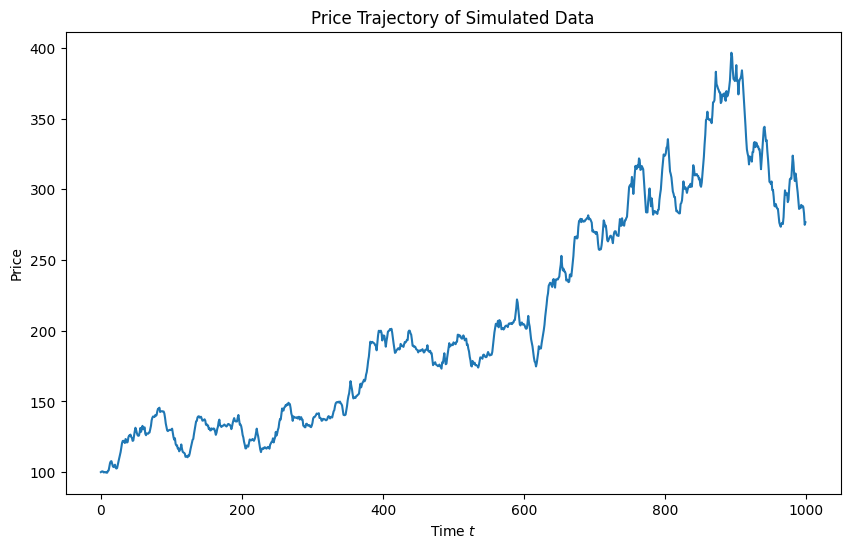

In [7]:
fig, ax = plt.subplots(figsize=(10,6))
plt.plot(compute_price(HMM.true_y/100))
plt.title('Price Trajectory of Simulated Data')
plt.xlabel('Time $t$')
plt.ylabel('Price')
plt.show()

## Gibbs Sampling and Parameter Estimation
This part performs Gibbs sampling to estimate parameters. `n_iter` and `n_burnin` are set for the number of iterations and burn-in period, respectively.

The Gibbs sampler consist in alternating the estimation and updating of the parameters of the model conditionally with the observations and the latent states and the estimation and updating of the unobserved Markov chain conditionally with the observations and the parameters of the model.

### HMM

In [10]:
g = gibbs(K, 0, train_test_split, HMM.true_y)
n_iter, n_burnin = 1500, 500
g.algorithm_est_ma(n_iter, n_burnin)   

  0%|          | 0/1500 [00:00<?, ?it/s]

### Parameters Estimation Results
We compare the estimated and true parameters ($M$, $\Sigma$, $\nu$, $Q$)

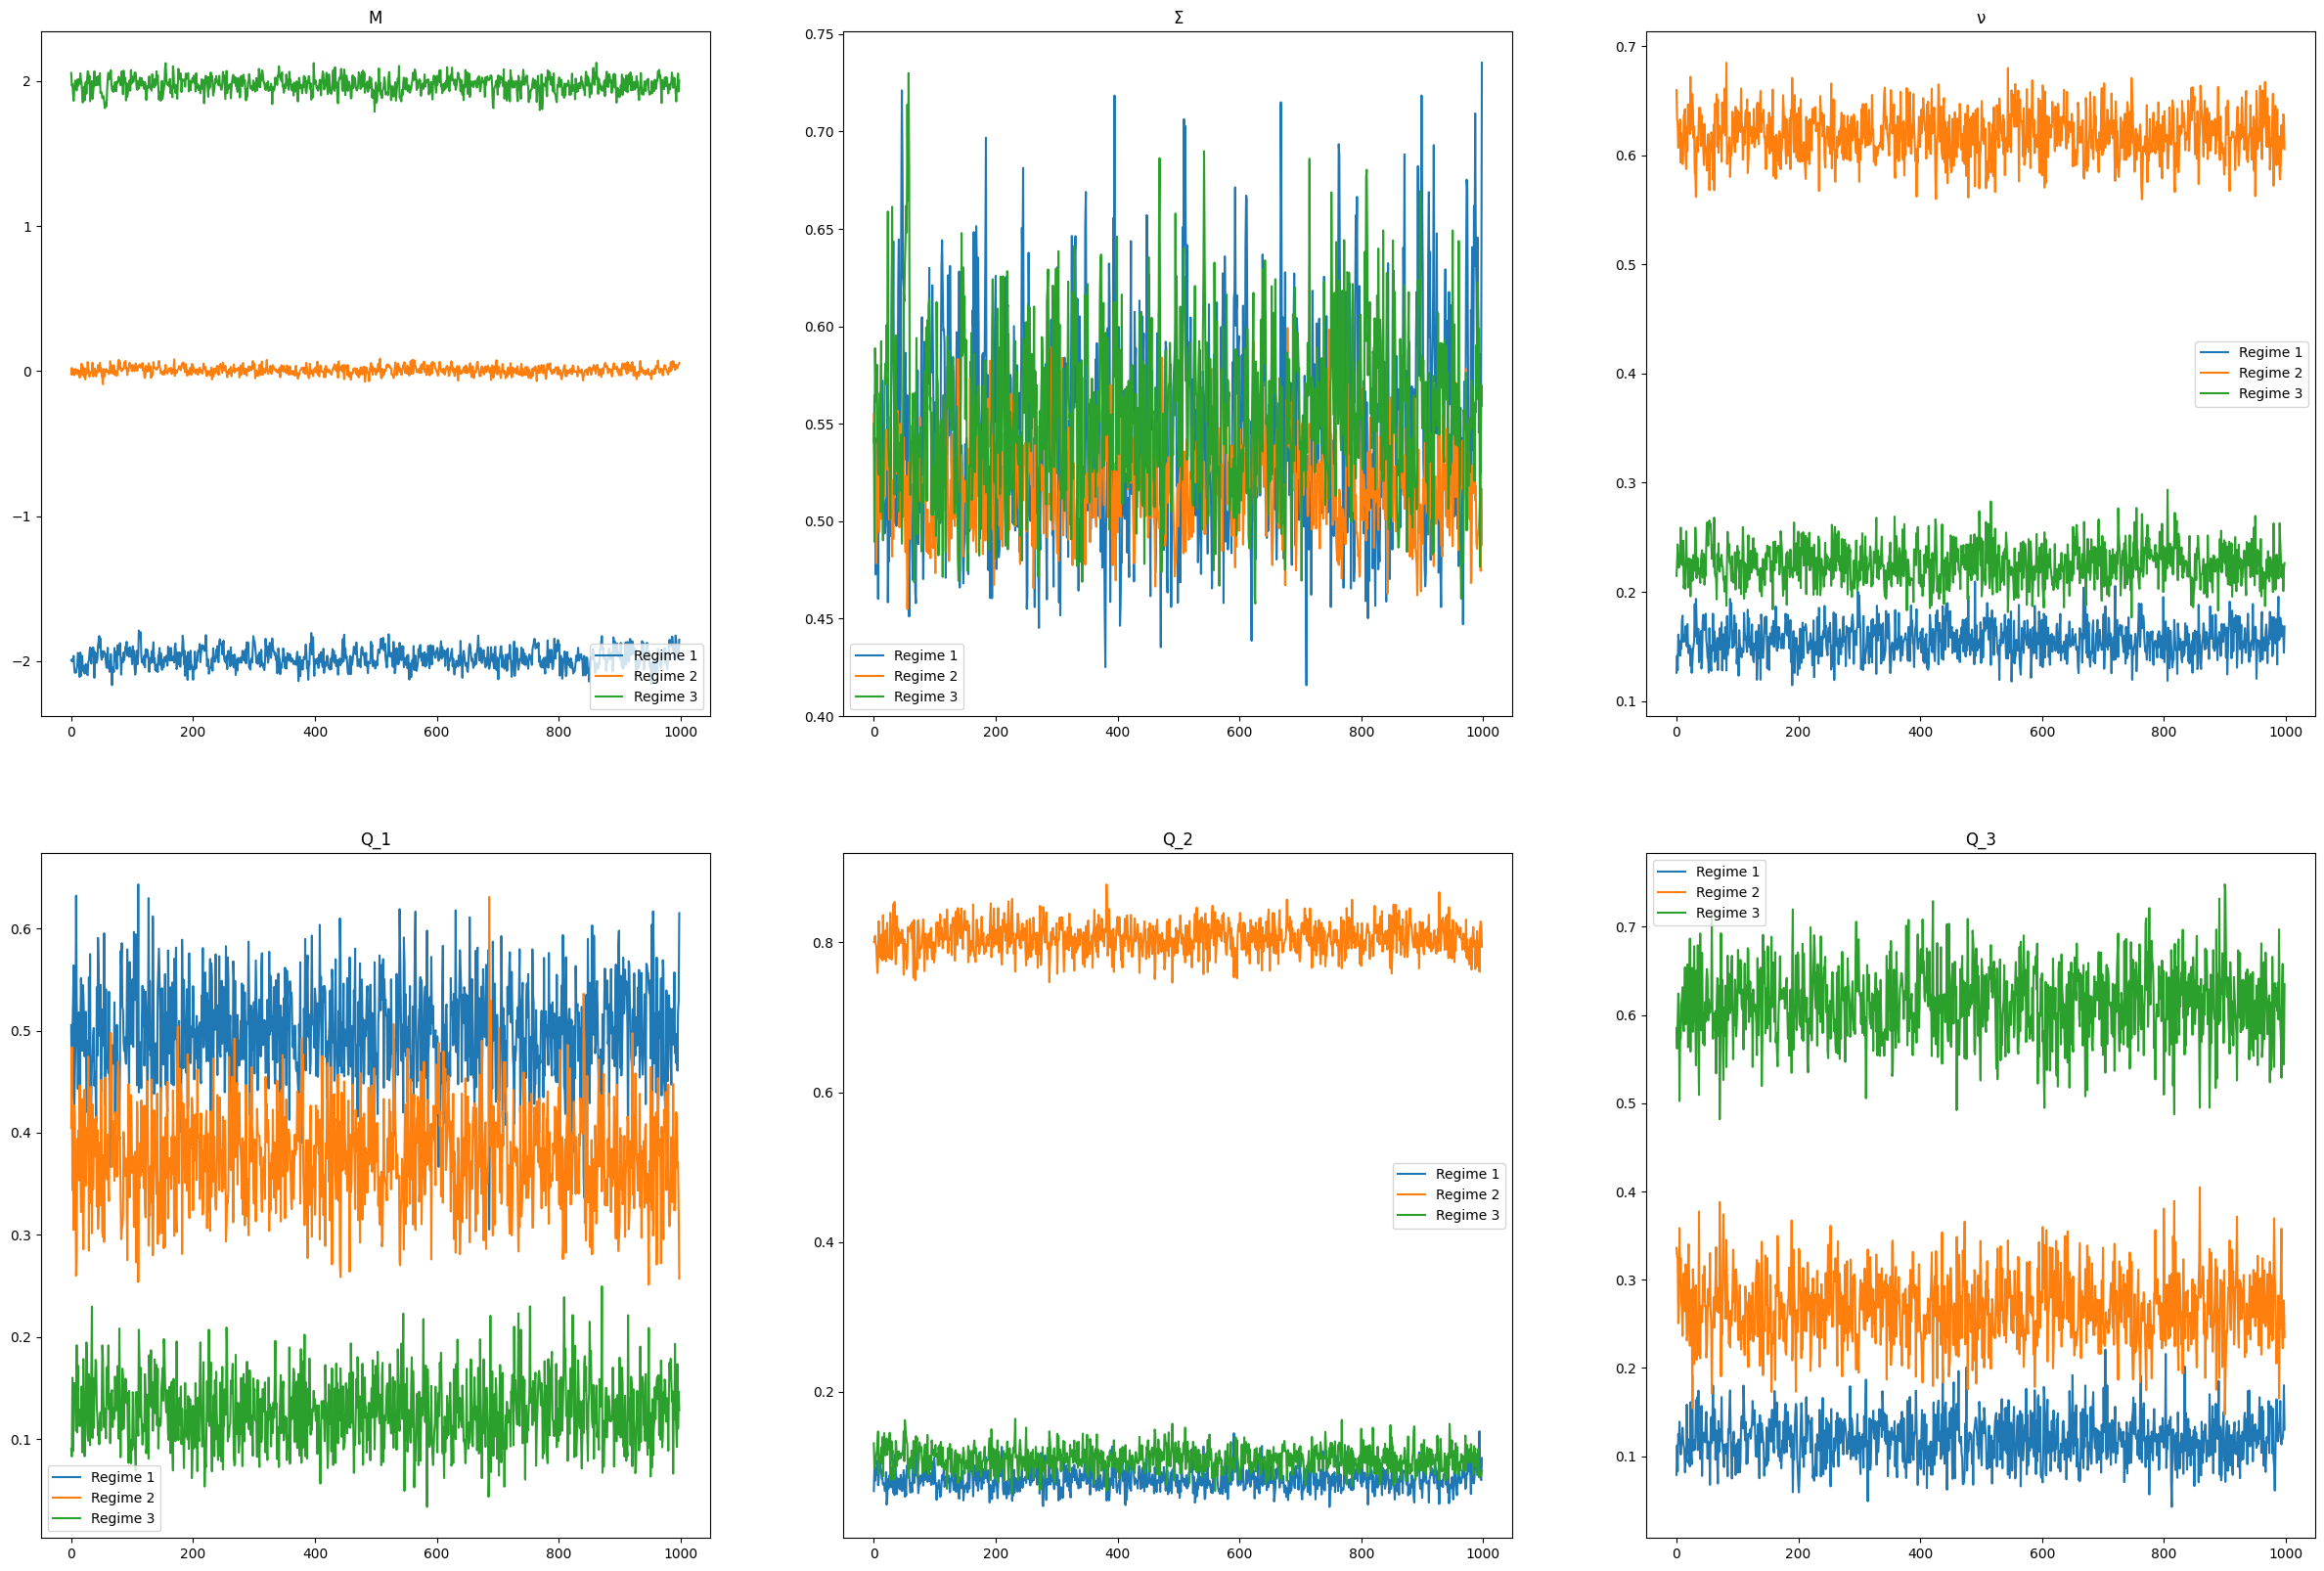

In [11]:
plt.subplots(figsize=(30,20))
plt.subplot(2,3,1)
plt.plot([g.res[k]['M'] for k in g.res.keys()])
plt.legend([f'Regime {i+1}' for i in range(K)])
plt.title('M')

plt.subplot(2,3,2)
plt.plot([g.res[k]['Σ'] for k in g.res.keys()])
plt.legend([f'Regime {i+1}' for i in range(K)])
plt.title('Σ')

plt.subplot(2,3,3)
plt.plot([g.res[k]['ν'] for k in g.res.keys()])
plt.legend([f'Regime {i+1}' for i in range(K)])
plt.title('ν')

for i in range(K):
    plt.subplot(2,3,4+i)
    plt.plot(np.array([g.res[k]['Q'] for k in g.res.keys()])[:,i])
    plt.legend([f'Regime {i+1}' for i in range(K)])
    plt.title(f'Q_{i+1}')
plt.show()

In [12]:
print('True M :\n', M)
print('Est. M (HMM) :\n', np.mean(np.array([g.res[k]['M'] for k in g.res.keys()]), axis=0))

print('\nTrue Σ :\n', Σ)
print('Est. Σ (HMM) :\n', np.mean(np.array([g.res[k]['Σ'] for k in g.res.keys()]), axis=0))

print('\nTrue Q :\n', Q)
print('Est. Q (HMM) :\n', np.mean(np.array([g.res[k]['Q'] for k in g.res.keys()]), axis=0))

print('\nTrue ν :\n', ν)
print('Est. ν (HMM) :\n', np.mean(np.array([g.res[k]['ν'] for k in g.res.keys()]), axis=0))

True M :
 [-2  0  2]
Est. M (HMM) :
 [-1.97862122  0.00583941  1.97498266]

True Σ :
 [0.5 0.5 0.5]
Est. Σ (HMM) :
 [0.54758499 0.52048991 0.5545094 ]

True Q :
 [[0.6 0.3 0.1]
 [0.1 0.8 0.1]
 [0.1 0.3 0.6]]
Est. Q (HMM) :
 [[0.49671745 0.37651677 0.12676579]
 [0.08396896 0.80568452 0.11034652]
 [0.11923913 0.26752316 0.61323771]]

True ν :
 [0.2 0.6 0.2]
Est. ν (HMM) :
 [0.15556175 0.61889773 0.22554052]


### Posterior Predictive Distribution
We visualize the posterior predictive distribution, which is the probability distribution that estimates future observations based on both the observed data and the uncertainty in model parameters in Bayesian statistics. It combines information from the data (observations) and the model (LMA-HMM) to provide a range of possible future outcomes.

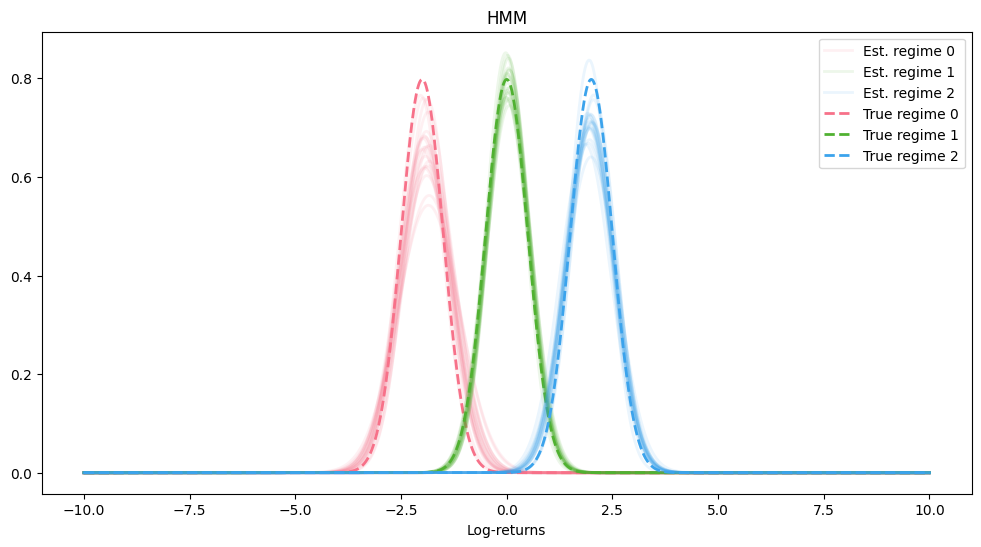

In [14]:
palette = sns.color_palette("husl", 3)
x_pdf = np.arange(-10, 10, 0.0001)

fig, ax = plt.subplots(figsize=(12,6))

for k in range(K):
    for key in list(g.res.keys())[-20:]:
        plt.plot(x_pdf, norm.pdf(x_pdf, g.res[key]['M'][k], g.res[key]['Σ'][k]), color=palette[k], linewidth=2, label='Est. regime ' + str(k), alpha=0.1)    
    plt.plot(x_pdf, norm.pdf(x_pdf, M[k], Σ[k]), '--', color=palette[k], linewidth=2, label='True regime ' + str(k))    
plt.title('HMM')
plt.xlabel('Log-returns')
legend_entries = np.append([plt.Line2D([0], [0], color=palette[k], lw=2, alpha=0.1) for k in range(K)], [plt.Line2D([0], [0], color=palette[k], lw=2, linestyle='--') for k in range(K)])
plt.legend(legend_entries, np.append(['Est. regime ' + str(k) for k in range(K)],['True regime ' + str(k) for k in range(K)]))
plt.show()

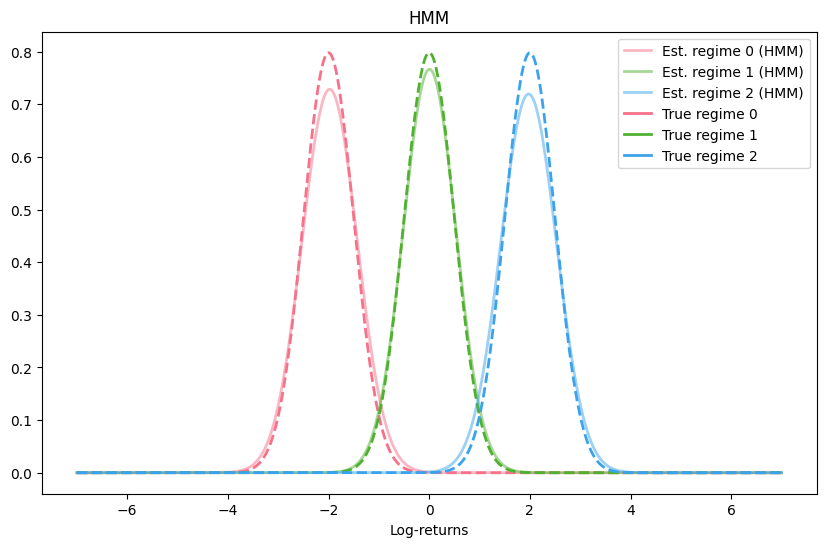

In [16]:
palette = sns.color_palette("husl", 3)
x_pdf = np.arange(-7, 7, 0.0001)

fig, ax = plt.subplots(figsize=(10,6))
for k in range(K):
    plt.plot(x_pdf, norm.pdf(x_pdf, np.mean(np.array([g.res[k]['M'] for k in g.res.keys()]), axis=0)[k], np.mean(np.array([g.res[k]['Σ'] for k in g.res.keys()]), axis=0)[k]), color=palette[k], linewidth=2, label='Est. regime ' + str(k) + ' (HMM)', alpha=0.5)    
    plt.plot(x_pdf, norm.pdf(x_pdf, M[k], Σ[k]), '--', color=palette[k], linewidth=2, label='True regime ' + str(k))    
plt.title('HMM')
plt.xlabel('Log-returns')
legend_entries = np.append(np.append([plt.Line2D([0], [0], color=palette[k], lw=2, alpha=0.5) for k in range(K)], [plt.Line2D([0], [0], color=palette[k], lw=2, alpha=1) for k in range(K)]), [plt.Line2D([0], [0], color=palette[k], lw=2, linestyle='--') for k in range(K)])
plt.legend(legend_entries, np.append(['Est. regime ' + str(k) + ' (HMM)' for k in range(K)],['True regime ' + str(k) for k in range(K)]))
plt.show()

### State Decoding Results
This section visualizes the results of the states decoding:
* the **in-sample decoding**, in the training period
* the **out-of-sample decoding**, in the test period

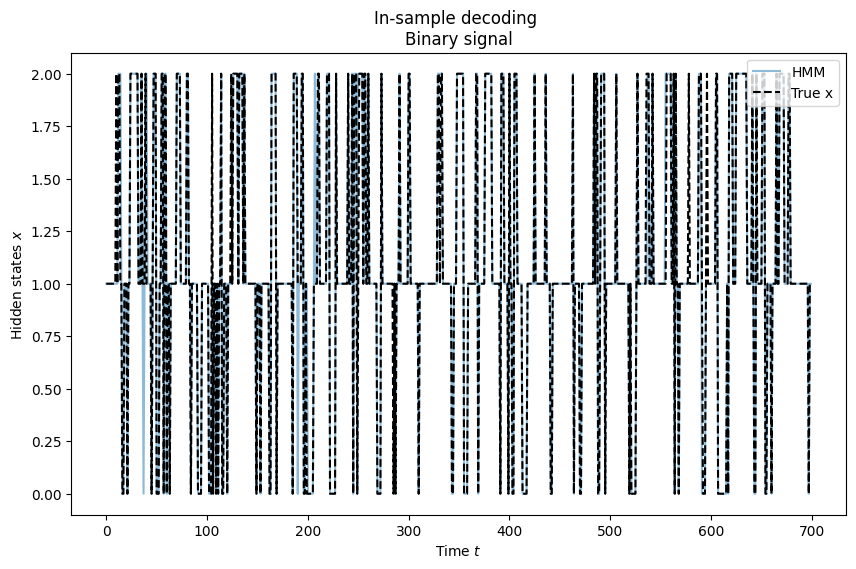

In-sample accuracy (HMM):0.98


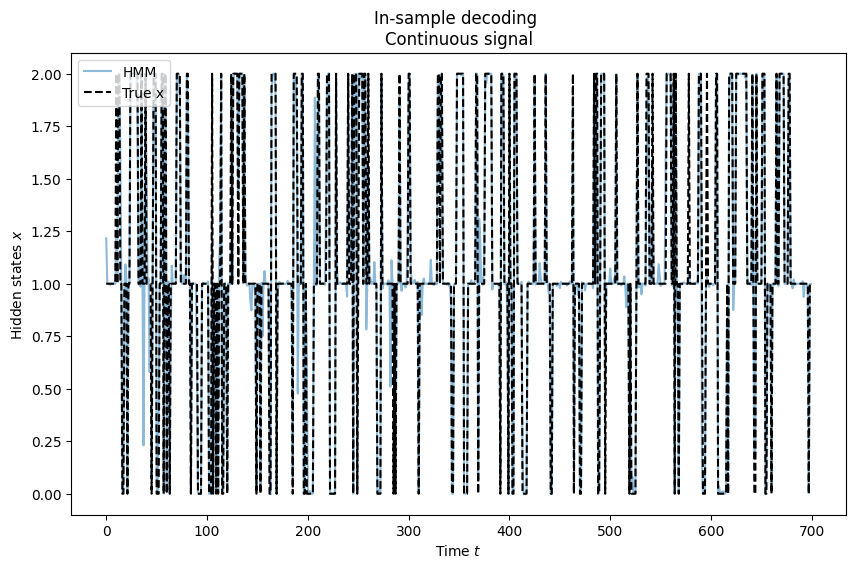

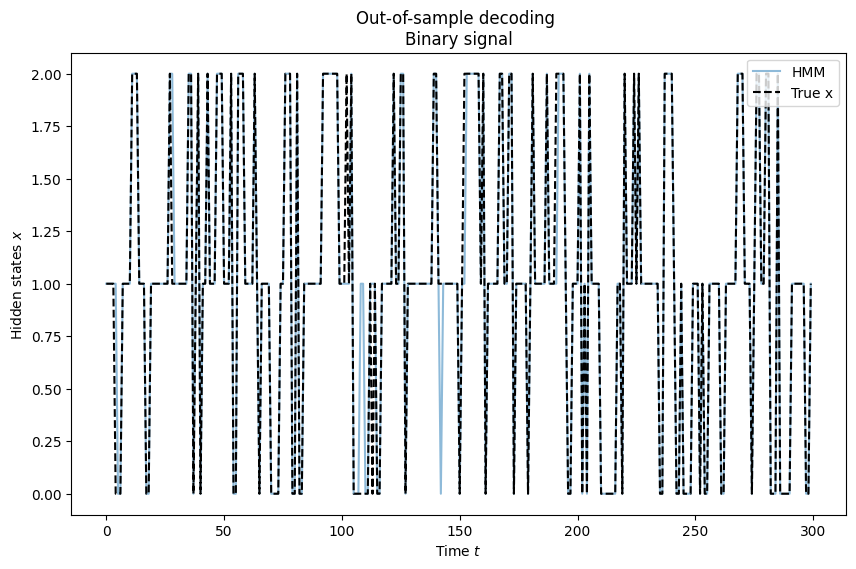

Out-of-sample accuracy (HMM):0.97


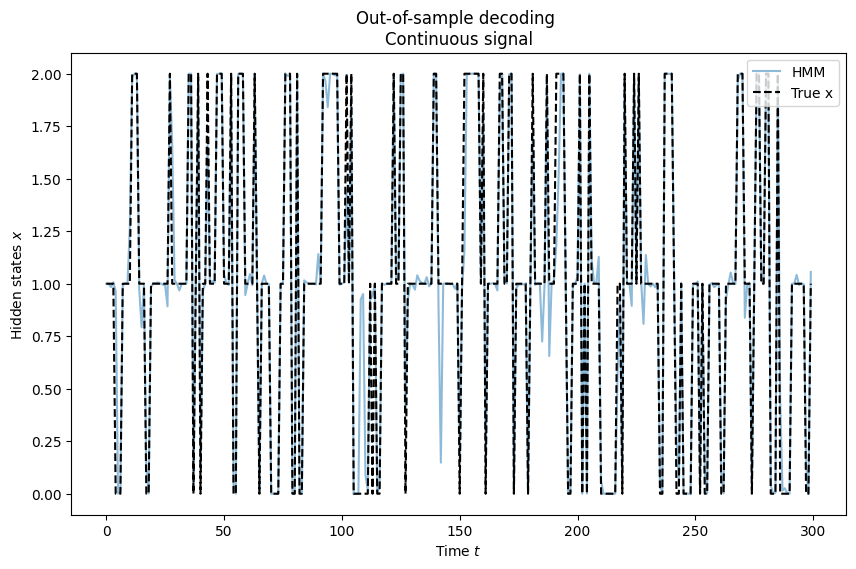

In [17]:
x_all_is = np.array([g.res[k]['x_is'] for k in g.res.keys()])
x_is = np.array([np.argmax(np.bincount(column)) for column in x_all_is.T.astype(int)])
x_is_cont = np.mean(x_all_is, axis=0)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_is, label='HMM', alpha=.5)
plt.plot(HMM.true_x_is, '--', label='True x', alpha=1, color='black')
plt.title('In-sample decoding \nBinary signal')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.legend(loc=1)
plt.show()
print('In-sample accuracy (HMM):' + str(np.round(len(x_is[x_is == HMM.true_x_is])/len(x_is), 2)))

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_is_cont, label='HMM', alpha=.5)
plt.plot(HMM.true_x_is, '--', label='True x', alpha=1, color='black')
plt.title('In-sample decoding \nContinuous signal')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.legend(loc=2)
plt.show()

x_all_oos = np.array([g.res[k]['x_oos'][-len(HMM.true_x_oos):] for k in g.res.keys()])
x_oos = np.array([np.argmax(np.bincount(column)) for column in x_all_oos.T.astype(int)])
x_oos_cont = np.mean(x_all_oos, axis=0)

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_oos, label='HMM', alpha=.5)
plt.plot(HMM.true_x_oos, '--', label='True x', alpha=1, color='black')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.title('Out-of-sample decoding \nBinary signal')
plt.legend(loc=1)
plt.show()
print('Out-of-sample accuracy (HMM):' + str(np.round(len(x_oos[x_oos == HMM.true_x_oos])/len(x_oos), 2)))

fig, ax = plt.subplots(figsize=(10,6))
plt.plot(x_oos_cont, label='HMM', alpha=.5)
plt.plot(HMM.true_x_oos, '--', label='True x', alpha=1, color='black')
plt.xlabel('Time $t$')
plt.ylabel('Hidden states $x$')
plt.title('Out-of-sample decoding \nContinuous signal')
plt.legend(loc=1)
plt.show()